In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
#常规的词典类
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
    
    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]
    def lookup_token(self, token):
        return self._token_to_idx[token]
    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):
        super(SequenceVocabulary, self).__init__(token_to_idx)
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)
    
    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [4]:
class NMTVectorizer(object):
    def __init__(self,source_vocab,target_vocab,max_source_length,max_target_length):
        """
        source_vocab: 源词典
        target_vocab: 目标词典
        max_source_length: 源样本的最大长度
        max_source_length: 目标样本的最大长度
        """
        
        self.source_vocab=source_vocab
        self.target_vocab=target_vocab
        
        self.max_source_length=max_source_length
        self.max_target_length=max_target_length
        
    def _vectorize(self,indices,vector_length=-1,mask_index=0):
        
        if vector_length<0:
            vector_length=len(indices)
        
        vector=np.zeros(vector_length,dtype=np.int64)
        vector[:len(indices)]=indices
        vector[len(indices):]=mask_index
        
        return vector
    
    def _get_source_indices(self,text):
        #获取开头begin_mask
        indices=[self.source_vocab.begin_seq_index]
        #获取每个文本的序号
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(' '))
        #加入结尾序号
        indices.append(self.source_vocab.end_seq_index)
        return indices
    
    def _get_target_indices(self,text):
        """
         同时返回两个，比如文本为 a b c d 那么返回的是
         x_indices:  begin_index a_index b_index c_index d_indec
         y_indices:  a_index     b_index c_index d_index end_index
         因为会需要将x_indices作为输入，将y_indices 作为预测的对象
        """
        indices = [self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab.end_seq_index]
        
        return x_indices,y_indices
    
    def vectorize(self,source_text,target_text,use_dataset_max_length=True):
        """
        最后一个参数为是否使用样本数据中最大的长度
        """
        source_vector_length=-1
        target_vector_length=-1
        
        if use_dataset_max_length:
            #加2 因为有begin_index 和end_index存在
            source_vector_length=self.max_source_length+2 
            target_vector_length=self.max_target_length+1
            
        source_indices=self._get_source_indices(source_text)
        source_vector=self._vectorize(source_indices,vector_length=source_vector_length,mask_index=self.source_vocab.mask_index)
        
        target_x_indices,target_y_indices=self._get_target_indices(target_text)
        target_x_vector=self._vectorize(target_x_indices,vector_length=target_vector_length,mask_index=self.target_vocab.mask_index)
        target_y_vector=self._vectorize(target_y_indices,vector_length=target_vector_length,mask_index=self.target_vocab.mask_index)
        
        return {
            'source_vector':source_vector,
            'target_x_vector':target_x_vector,
            'target_y_vector':target_y_vector,
            'source_length':len(source_indices)
        }
    
    @classmethod
    def from_dataframe(cls,bitext_df):
        
        source_vocab=SequenceVocabulary()
        target_vocab=SequenceVocabulary()
        
        max_source_length=0
        max_target_length=0
        
        
        for _,row in bitext_df.iterrows():
            source_tokens=row['source_language'].split(' ')
            
            if len(source_tokens)>max_source_length:
                max_source_length=len(source_tokens)
            
            for token in source_tokens:
                source_vocab.add_token(token)
                
            target_tokens=row['target_language'].split(' ')
            if len(target_tokens)>max_target_length:
                max_target_length=len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
        
        
        return cls(source_vocab,target_vocab,max_source_length,max_target_length)

In [5]:
class NMTDataset(Dataset):
    
    def __init__(self,text_df,vectorizer):
        
        self.text_df=text_df
        self._vectorizer=vectorizer
        
        self.train_df=self.text_df[self.text_df.split=='train']
        self.train_size=len(self.train_df)
        
        self.val_df=self.text_df[self.text_df.split=='val']
        self.val_size=len(self.val_df)
        
        self.test_df=self.text_df[self.text_df.split=='test']
        self.test_size=len(self.test_df)
        
        self._lookup_dict={
            'train':(self.train_df,self.train_size),
            'val':(self.val_df,self.val_size),
            'test':(self.test_df,self.test_size)
        }
        
        self.set_split('train')
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls,dataset_csv):
        text_df=pd.read_csv(dataset_csv)
        train_subset=text_df[text_df.split=='train']
        ###???
        return  cls(text_df,NMTVectorizer.from_dataframe(text_df))
    def get_vectorizer(self):
        return self._vectorizer
    
    def set_split(self,split='train'):
        self._target_split=split
        self._target_df,self._target_size=self._lookup_dict[split]
    
    def __len__(self):
        return self._target_size
    
    def __getitem__(self,index):
        """
        根据index 获取item
        """
        row=self._target_df.iloc[index]
        
        vector_dict=self._vectorizer.vectorize(row.source_language,row.target_language)
        
        return {
            'x_source': vector_dict['source_vector'],
            'x_target': vector_dict['target_x_vector'],
            'y_target': vector_dict['target_y_vector'],
            'x_source_length':vector_dict['source_length']
        }
    
    def get_num_batches(self,batch_size):
        
        return len(self)//batch_size

In [6]:
def generate_nmt_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        lengths=data_dict['x_source_length'].numpy()
        #获取排序后text 的序号
        ##排序是因为后续使用了pack_padded_sequence
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        out_data_dict = {}
        for name,tensor in data_dict.items():
            out_data_dict[name]=data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

In [7]:
class NMTEncoder(nn.Module):
    
    def __init__(self,num_embeddings,embedding_size,rnn_hidden_size):
        super(NMTEncoder,self).__init__()
        
        self.source_embedding=nn.Embedding(num_embeddings,embedding_size,padding_idx=0)
        self.birnn=nn.GRU(embedding_size,rnn_hidden_size,bidirectional=True,batch_first=True)
    
    def forward(self,x_source,x_lengths):
        """
        return:
                x_unpacked.shape = (batch, seq_size, rnn_hidden_size * 2)
                x_birnn_h.shape = (batch, rnn_hidden_size * 2)
        """
        x_embedded=self.source_embedding(x_source)
        ##x_embedded 是batch_first的，并且 batch_size sequence_length,embedd_size
        ##其中每个sequence_lenth 要根据长度进行排序
        x_packed=pack_padded_sequence(x_embedded,x_lengths.detach().cpu().numpy(),batch_first=True)
        
        #x_birnn_h shape is (num_layers*num_directions,batch,hidden_size)
        x_birnn_out,x_birnn_h=self.birnn(x_packed)
        
        #x_birnn_h has change ( batch,2,hidden_size)
        x_birnn_h=x_birnn_h.permute(1,0,2)
        
        #x_birnn_h has change (batch,2*hidden_size)
        x_birnn_h=x_birnn_h.contiguous().view(x_birnn_h.size(0),-1)
        #x_unpacked shape is     (batch_Size,seq_length.2*hidden_size)
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        
        return x_unpacked,x_birnn_h

def verbose_attention(encoder_state_vectors, query_vector):
    """
    即将decoder 每个时间步的输出h_t 与 encoder_state “也就是所有h_t t为时间步  形成的矩阵”相乘 得到另一个与h_t相同维度的向量，这个即为
    attentiin
    
    encoder_state_vector 的shape 为 (batch_size,seq_length，2*hidden_size)    这里的hidden_size 为encoder 的hidden_size
    query_vector 的shape  为（batch_size,hidden_size） 这里的size是decode 中的hidden_size
    
    return:
       context_vectors: (batch_size,decode_hidden_size)
       vector_probabilities：(batch_size,seq_length)
    """
    #
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    
    #vector_scores的shape 为(batch_size,seq_length)
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)
    
    vector_probabilities = F.softmax(vector_scores, dim=1)
    #weight_vectors 的shape 为 (batch_size,seq_length，2*hidden_size)  
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    
    context_vectors = torch.sum(weighted_vectors, dim=1)
    
    #
    return context_vectors, vector_probabilities, vector_scores


def terse_attention(encoder_state_vectors, query_vector):
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities

In [8]:
class NMTDecoder(nn.Module):
    
    def  __init__(self,num_embeddings,embedding_size,rnn_hidden_size,bos_index):
        """
        bos_index(int): begin-of-sequence index
        """
        super(NMTDecoder,self).__init__()
        
        self._rnn_hidden_size=rnn_hidden_size
        
        self.target_embedding=nn.Embedding(num_embeddings,embedding_size,padding_idx=0)
        
        self.gru_cell=nn.GRUCell(embedding_size+rnn_hidden_size,rnn_hidden_size)
        
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        
        self.bos_index = bos_index
    
    def _init_indices(self,batch_size):
        #即根据batch_size 创建相同数量的begin_of index
        return torch.ones(batch_size,dtype=torch.int64)*self.bos_index
    
    def _init_context_vectors(self, batch_size):
        return torch.zeros(batch_size,self._rnn_hidden_size)
    
    def forward(self,encoder_state,initial_hidden_state,target_sequence):
        
        """
        encoder_state 是encoder的输出，其实就是encoder的每个time_step的形成的矩阵
        
        initial_hidden:是encoder的最后一层隐藏层输出
        
        target_sequence：目标文本的数据
        """
        #假设输入的target_sequence 的size 是（Batch,Seq）
        #使用permute后变为（seq,Batch）
        target_sequence=target_sequence.permute(1,0)
        
        #获取输出sequence的文本长度，也就是总时间步
        output_sequence_size=target_sequence.size(0)
        
        #使用encoder的最后一层隐藏层作为输入，获取h_t
        h_t=self.hidden_map(initial_hidden_state)
        
        #获取batch_size
        batch_size=encoder_state.size(0)
        
        
        #context_vectors 的shape  为 （batch，decode_hidden_size）
        context_vectors=self._init_context_vectors(batch_size)
        
        
        
        #初始化y_t的第一个序号为BOS
        y_t_index = self._init_indices(batch_size)
        
        #将初始化的tensor迁移到相同的设备上
        h_t=h_t.to(encoder_state.device)
        y_t_index=y_t_index.to(encoder_state.device)
        context_vectors=context_vectors.to(encoder_state.device)
        
        #用来保存计算途中输出的tensor
        output_vectors=[]
        self._cached_p_attn=[]
        self._cached_ht=[]
        self._cached_decoder_stata=encoder_state.cpu().detach().numpy()
        
        
        for i in range(output_sequence_size):
            
            #获取当前batch要预测的text targat_sequence的shape 为（sequence_length,batch_size）
            #y_t_index shape 为（1，batch_size)
            y_t_index=target_sequence[i]
            
            #将上一个time_step 预测出来的词作为词向量作为输入
            y_input_vector=self.target_embedding(y_t_index)
            
            
            #y_input_vector 的shape 为（batch_size,embedding_size） context_vector的shape 为(batch_size,hidden_size)
            #拼接后为 （batch_size,embedding_size+rnn_hidden_size）
            rnn_input=torch.cat([y_input_vector,context_vectors],dim=1)
            
            
            #使用gruCell，gruCell相当于自己使用使用for循环实现gru,h_t 为当前time_step的输出
            #h_t shape（batch_size,hidden_size）
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            
            
            #context_vectors 是计算得出的attention 和 h_t 一样的shape
            context_vectors,p_attn,_=verbose_attention(encoder_state_vectors=encoder_state,query_vector=h_t)
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            
            
            #将两个向量合起来，用作预测token，
            #此时prediction_vector 的shape 为 (batch_size,2*hidden_size) hidden_size 为encoder的hidden_size
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            
            
            #加入预测的token
            #此先说明，由于for循环是根据sequence_length（也就是总时间步）每次是预测当前batch的这一时间步的token
            #score_for_y_t_index 的shape 是（batch_size,num_embeddings）
            output_vectors.append(score_for_y_t_index)
            
            
        #将list stack然后再变更形状，最终output_vectors的shape 是 (batch_size,seq_length,num_embeddings)    
        output_vectors=torch.stack(output_vectors).permute(1,0,2)
        
        return output_vectors

In [9]:
class NMTModel(nn.Module):
    """
    将encoder 和decoder两个模型联合起来
    """
    def __init__(self,source_vocab_size,source_embedding_size,target_vocab_size,target_embedding_size,encoding_size,target_bos_index):
        """
        source_vocab_size: 源语言的词典大小
        source_embedding_size:encoder 的词向量的维度
        target_vocab_size: 目标语言的词典大小
        target_embedding_size: decoder 的词典向量的维度
        encoding_size:  enocder 的hidden_size
        target_bos_index: 开始token  <BEGIN>的
        """
        
        super(NMTModel,self).__init__()
        
        self.encoder=NMTEncoder(num_embeddings=source_vocab_size,
                               embedding_size=source_embedding_size,
                               rnn_hidden_size=encoding_size)
        decoding_size=encoding_size*2
        self.decoder=NMTDecoder(num_embeddings=target_vocab_size,
                               embedding_size=target_embedding_size,
                               rnn_hidden_size=decoding_size,
                               bos_index=target_bos_index)
    
    def forward(self,x_source,x_source_length,target_sequence):
        #encoder 计算得出所有h_t 的集合和最后一层 t=seq_length 的集合
        encoder_state,final_hidden_states=self.encoder(x_source,x_source_length)
        
        decoded_states=self.decoder(encoder_state=encoder_state,
                                    initial_hidden_state=final_hidden_states,
                                    target_sequence=target_sequence)
        return decoded_states

In [10]:
#set seed
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

#处理文件
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
#获取训练的状态
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

#在训练时更新训练状态
def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred,y_true):
    #y_pred 是模型的输出，如果是三维的那就转化为矩阵
    #y_true是真实的值，为矩阵就转化为一维向量
    """
    y_pred 的shape 为(batch_size,seq_length,embedding_size)
    y_true 的shape 为(batch_size,seq_length)
    """
    
    if len(y_pred.size())==3:
        y_pred=y_pred.contiguous().view(-1,y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    _,y_pred_indices=y_pred.max(dim=1)
    #根据真实的字符得出与模型输出的字符相比较     1 0 1 0 1 
    correct_indices=torch.eq(y_pred_indices,y_true).float()
    #两个tensor得出不相等的每项，相等为0，不想等为1      即真实值与mask  假设y_true 为 2 4 6 0 （0为mask_index）
    #                                                                                  0 0 0 0
    #则valil_indices 为                                                                1 1 1 0
    valid_indices = torch.ne(y_true, mask_index).float()
    #除去mask 后预测成功的值
    n_correct = (correct_indices * valid_indices).sum().item()
    #真实字符个数
    n_valid = valid_indices.sum().item()
    #准确率
    return n_correct / n_valid * 100
def sequence_loss(y_pred, y_true, mask_index):
    """
    计算loss
    """
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

def plot_performance(train_state,args):
        """
        画图
        """
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(train_state["train_loss"], label="train")
        plt.plot(train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(train_state["train_acc"], label="train")
        plt.plot(train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(args.save_dir, "performance.png"))

        # Show plots
        plt.show()

In [11]:
#模型的参数
args = Namespace(dataset_csv="../data/nmt/simplest_eng_fra.csv",
                 model_state_file="model.pth",
                 save_dir="model_storage/nmt_luong_no_sampling",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=False,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=64,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=64, 
                 target_embedding_size=64,
                 encoding_size=64,
                 catch_keyboard_interrupt=True)
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))    

#check CUDA
if  torch.cuda.is_available():
    args.cuda=True

args.device=torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))
set_seed_everywhere(args.seed, args.cuda)
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/nmt_luong_no_sampling\model.pth
Using CUDA: True


In [12]:
#创建数据集
dataset=NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
#得到向量工具
vectorizer=dataset.get_vectorizer()

In [13]:
#创建模型
model=NMTModel(source_vocab_size=len(vectorizer.source_vocab),
              source_embedding_size=args.source_embedding_size,
              target_vocab_size=len(vectorizer.target_vocab),
              target_embedding_size=args.target_embedding_size,
              encoding_size=args.encoding_size,
              target_bos_index=vectorizer.target_vocab.begin_seq_index)

In [14]:
print(model)

NMTModel(
  (encoder): NMTEncoder(
    (source_embedding): Embedding(3432, 64, padding_idx=0)
    (birnn): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): NMTDecoder(
    (target_embedding): Embedding(5734, 64, padding_idx=0)
    (gru_cell): GRUCell(192, 128)
    (hidden_map): Linear(in_features=128, out_features=128, bias=True)
    (classifier): Linear(in_features=256, out_features=5734, bias=True)
  )
)


In [15]:
"""
训练过程，和之前的一样
"""
model=model.to(args.device)

optimizer=optim.Adam(model.parameters(),lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)
epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

In [16]:
try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
            loss.backward()
            optimizer.step()
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        
        
        ## val
        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the running loss and accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])
        
        
        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'] )
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

In [17]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt


chencherry=bleu_score.SmoothingFunction()

In [18]:
def sentence_from_indices(indices,vocab,strict=True,return_string=True):
    """
    从indices 获取句子
    """
    ignore_indices=set([vocab.mask_index,vocab.begin_seq_index,vocab.end_seq_index])
    out=[]
    
    for index in indices:
        if index ==vocab.begin_seq_index and strict:
            continue
        
        elif index==vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out

#供测试集数据使用
class NMTSampler:
    
    def __init__(self,vectorizer,model):
        
        self.vectorizer=vectorizer
        self.model=model
    
    def apply_to_batch(self,batch_dict):
        
        self._last_batch=batch_dict
        
        #根据数据得到模型的输出
        #y_pred shape为(batch_size,seq_length,num_embeddings)  
        y_pred=self.model(x_source=batch_dict['x_source'],
                         x_source_length=batch_dict['x_source_length'],
                         target_sequence=batch_dict['x_target'])
        
        self._last_batch['y_pred'] = y_pred
        
        
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        #attention_batched 此时的shape 为  (batch_size,seq_length,seq_length)
        self._last_batch['attention'] = attention_batched
    
    
    def _get_source_sentence(self, index, return_string=True):
        """
        获取源语言的样本
        """
        #根据index 获取源语言样本
        #indices 的shape 为（seq_len,embedding_size）
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        #获取句子，为['token_a','token_b'...]格式
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_reference_sentence(self, index, return_string=True):
        """
        获取目标语言要预测的，也就是实际值
        """
        #根据index 获取y_target 即假设模型要预测的目标语言真样本
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        
        vocab = self.vectorizer.target_vocab
        #获取句子，为['token_a','token_b'...]格式
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        """
        获取模型输出，也就是模型预测的目标语言
        """
        #将预测的返回的y_pred 的使用max函数获取预测的token all_indices 的shape为（batch_size,seq_len)
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        #根据index 获取某一样本模型预测的结果
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)
    
    
    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        #获取评分
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [19]:
#模型
model = model.eval().to(args.device)
#创建类
sampler = NMTSampler(vectorizer, model)
#设置数据集为测试集
dataset.set_split('test')
#数据集设置
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)

test_results = []
#获取模型预测的结果
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.4770359973529835, 0.4757214942584156)

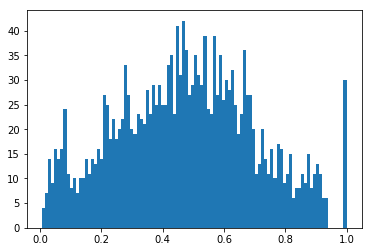

In [20]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);

np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

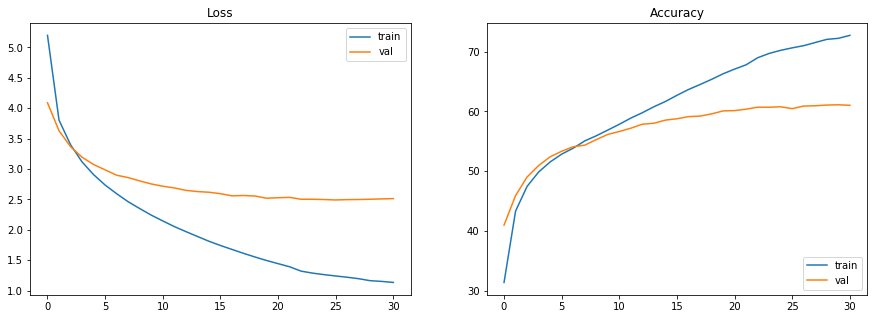

In [25]:
#画出loss和acc的曲线图
plot_performance(train_state,args)

In [21]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [22]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [23]:
top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

60

C:\Users\505\Anaconda3\envs\dp\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


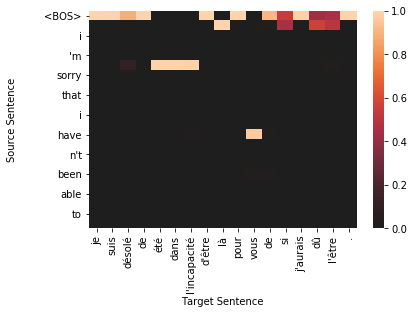

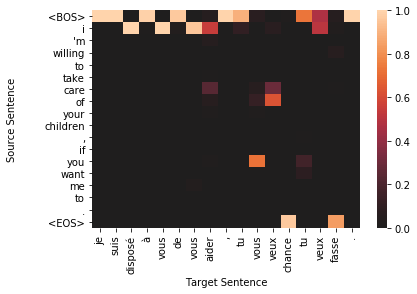

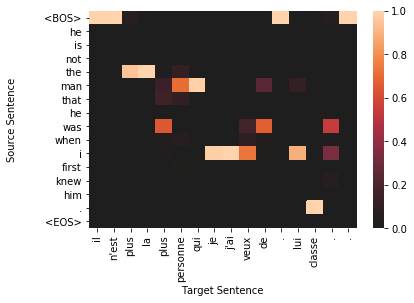

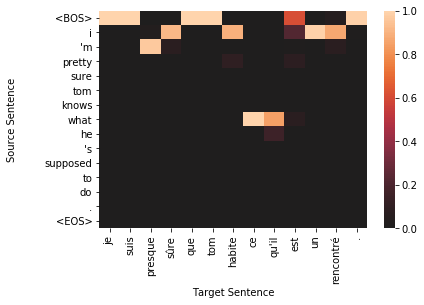

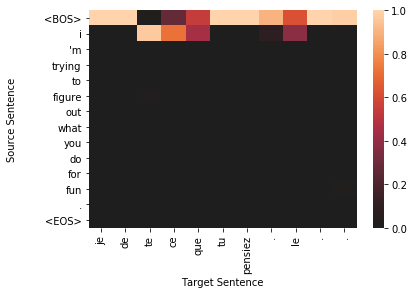

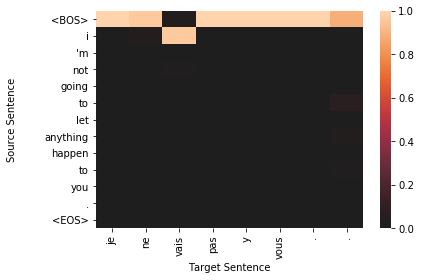

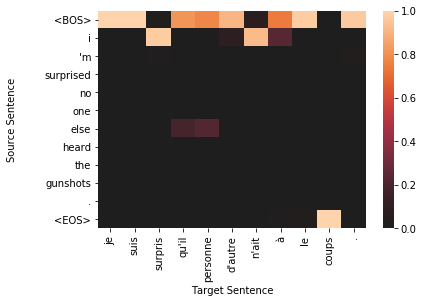

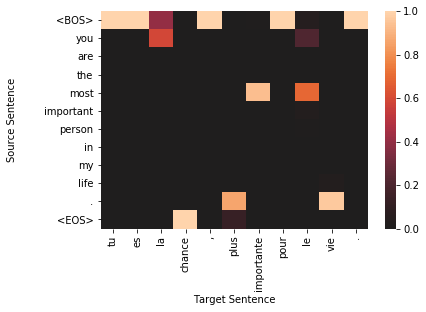

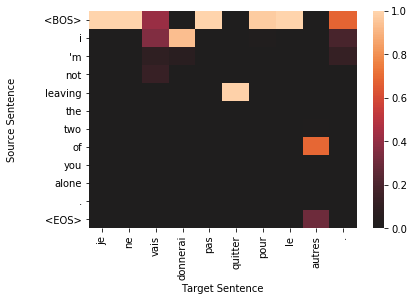

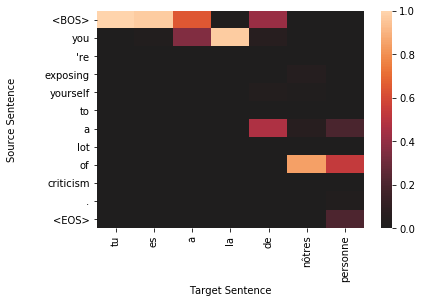

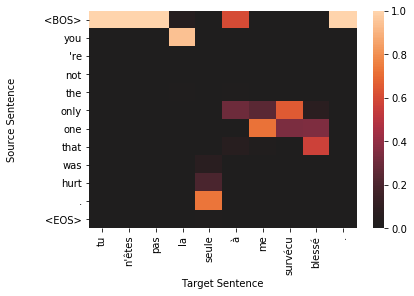

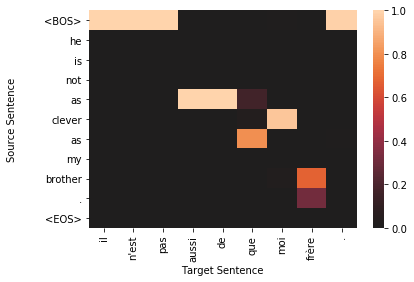

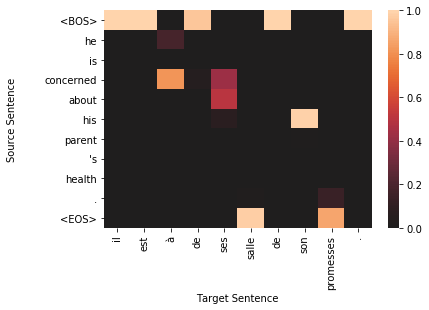

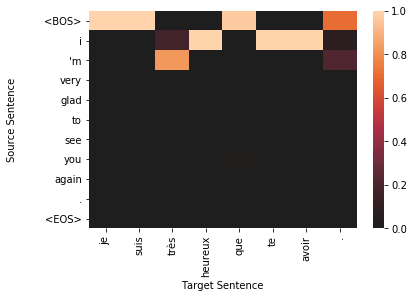

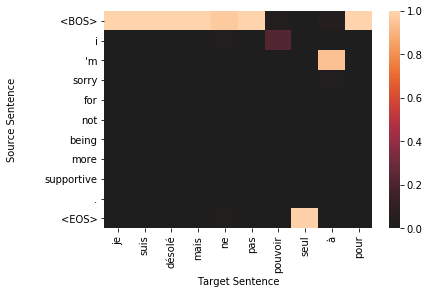

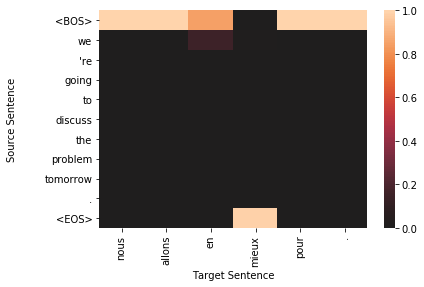

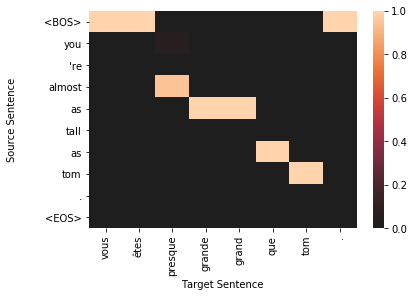

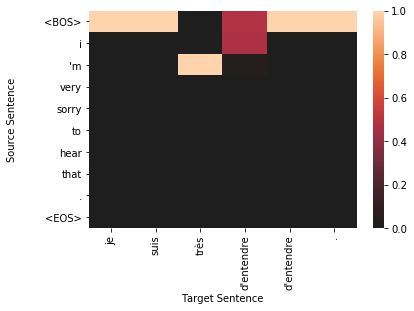

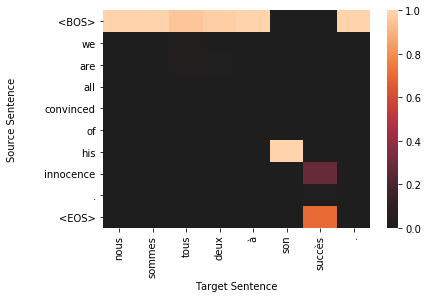

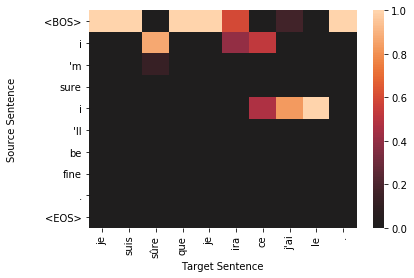

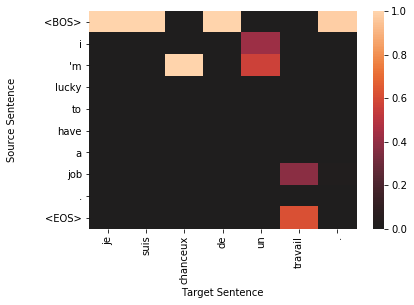

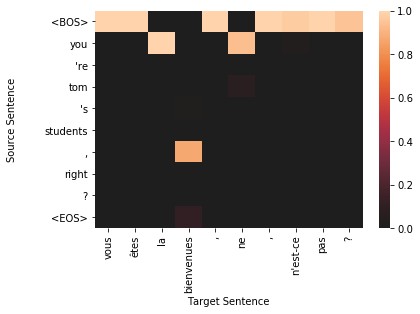

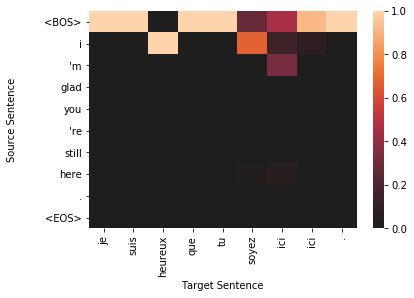

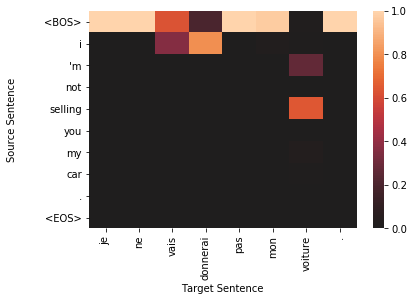

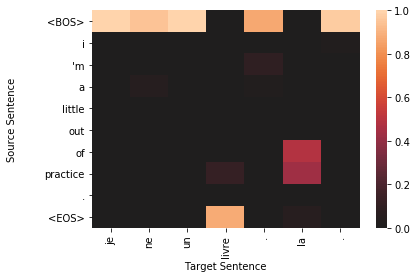

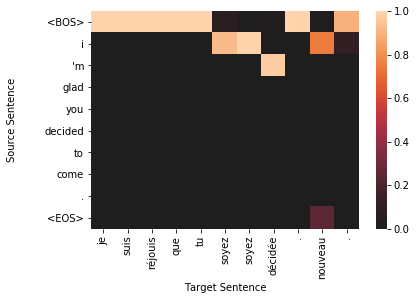

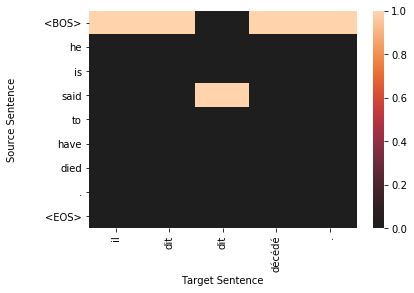

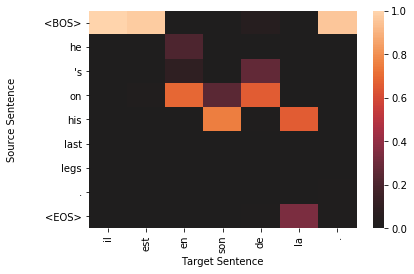

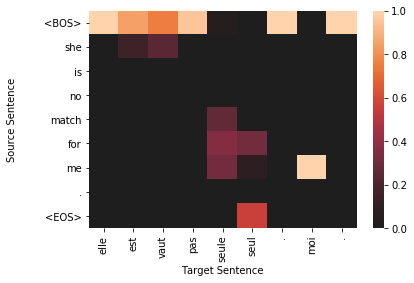

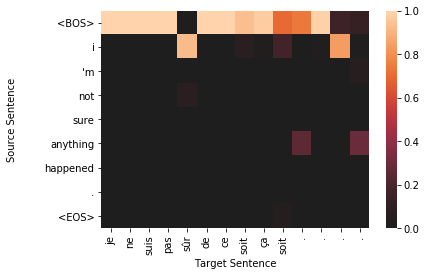

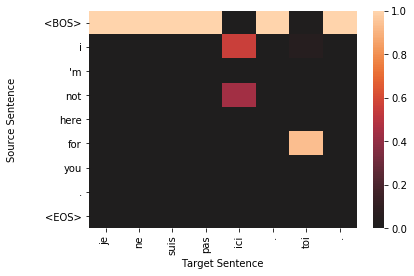

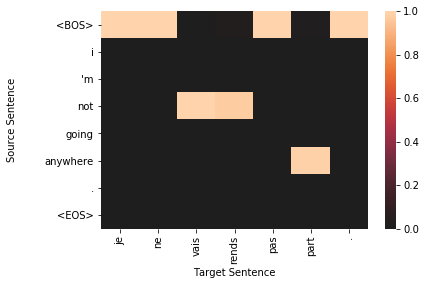

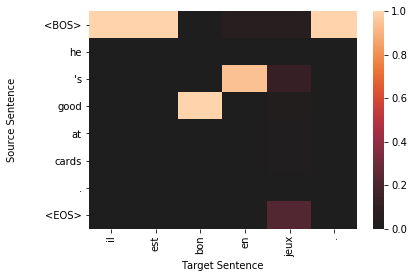

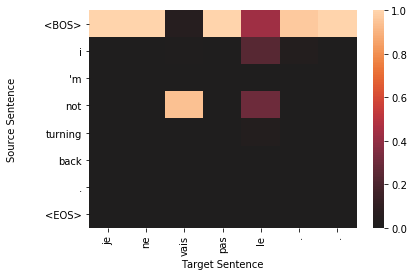

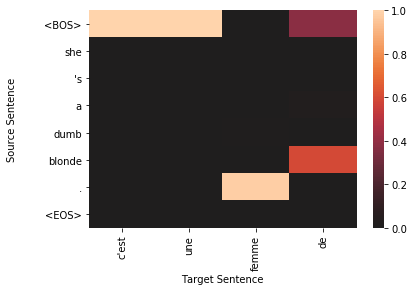

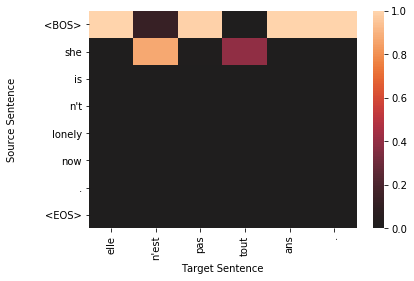

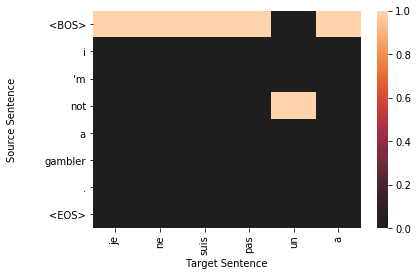

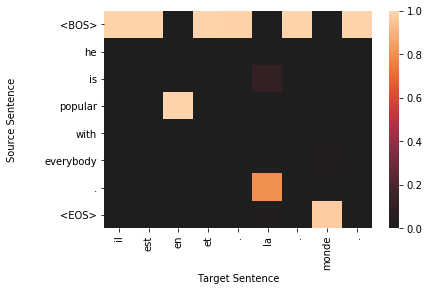

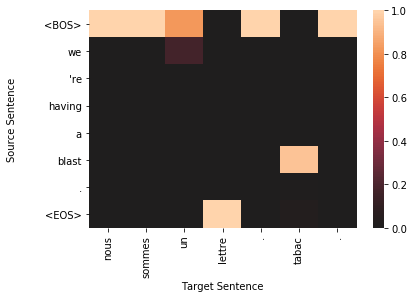

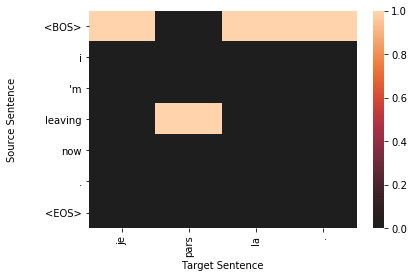

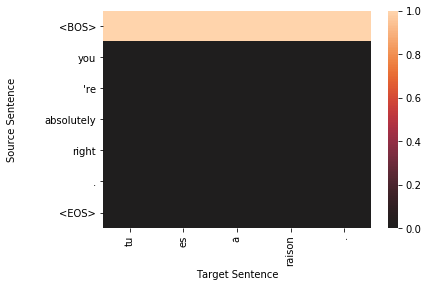

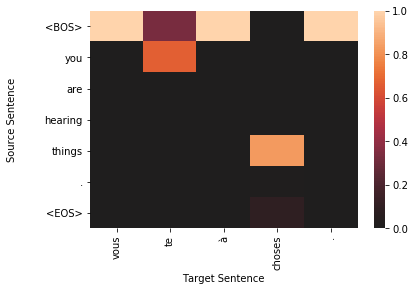

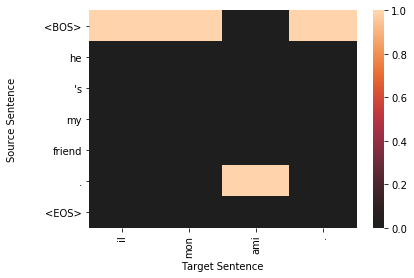

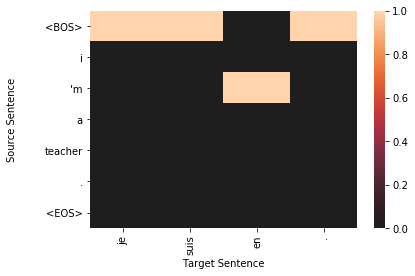

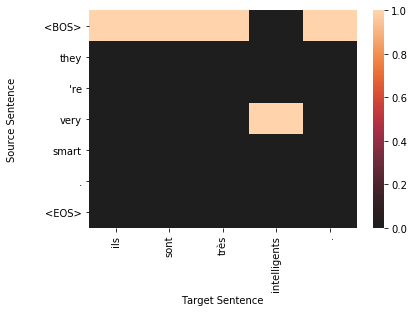

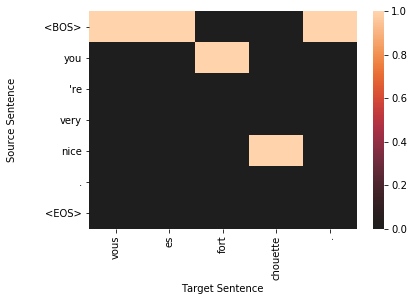

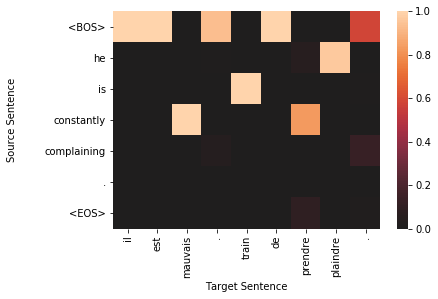

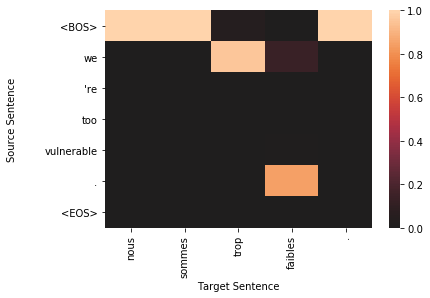

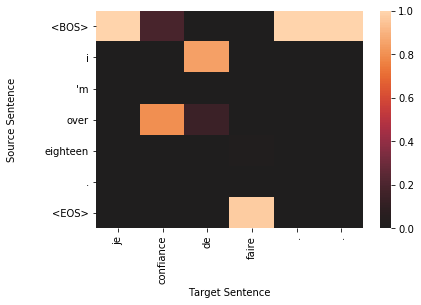

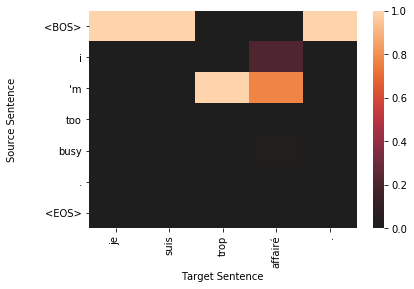

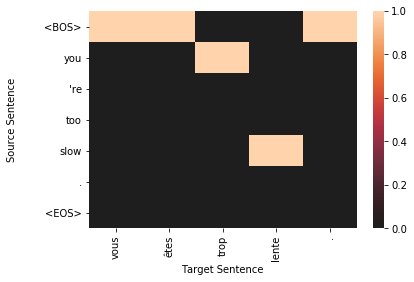

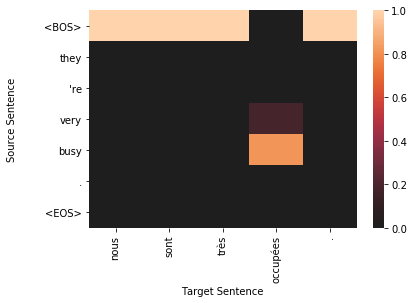

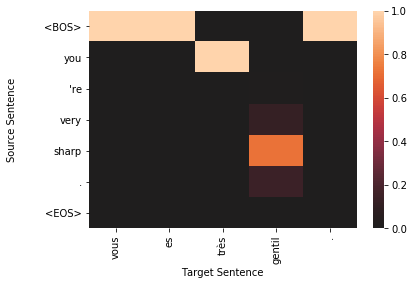

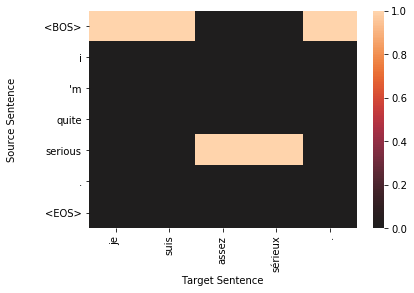

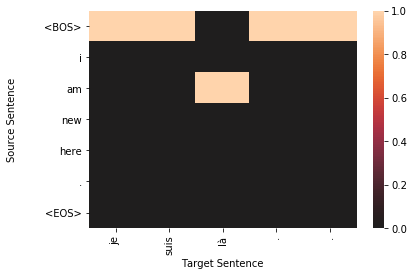

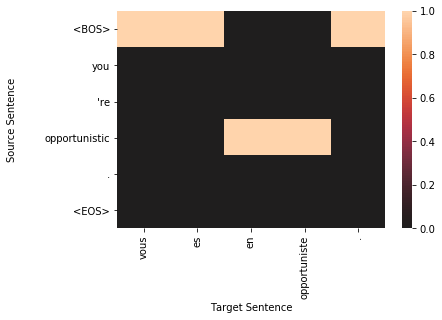

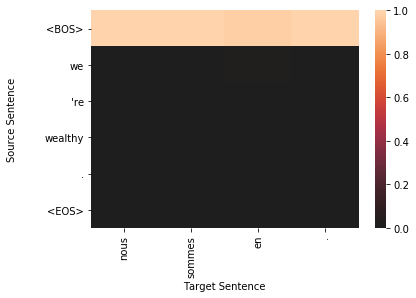

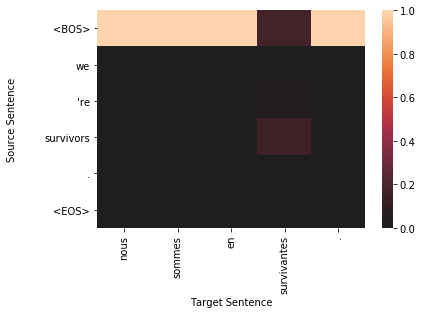

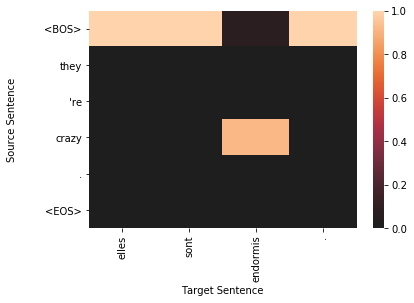

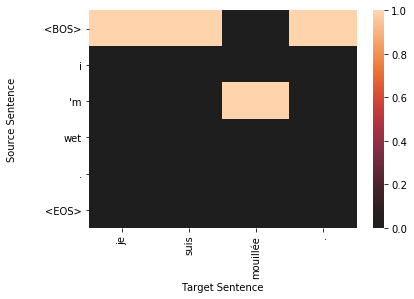

In [24]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")

In [28]:
def sentence_from_indices(indices,vocab,strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)
def get_source_sentence(vectorizer,batch_dict,index):
    """
    获取源语言的文本句子
    """
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    """
    获取目标语言的真实句子
    """
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    """
    根据模型得出预测结果
    """
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_length=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'])
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)
def get_all_sentences(vectorizer, batch_dict, index):
    """
    封装上述三个函数
    """
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}


In [31]:
#示例输出
results = get_all_sentences(vectorizer, batch_dict, 1)
results

{'source': "i 'm willing to take care of your children , if you want me to .",
 'truth': "je suis prêt à m'occuper de tes enfants , si tu veux que je le fasse .",
 'sampled': 'je suis disposé à vous de vous vu et si vous veux chance tu vous fasse .'}